![](png/Data_Processing_1.png)
![](png/Data_Processing_2.png)

# 1. 每一個id運動項目做了多久

1. **導入庫**：
   - 引入 `pandas` 和 `datetime` 模塊。

2. **定義 `process_action_data` 函數**：
   - 設定參數：
     - `file_path`：讀取數據的文件路徑。
     - `output_file`：保存處理後數據的文件路徑。
     - `merge_threshold`：合併短時間內動作的時間閾值。
     - `duration_threshold`：記錄動作的最小持續時間閾值。

3. **讀取數據文件**：
   - 使用 `pd.read_csv` 讀取文件，並將列命名為 `ID`, `Time`, `Action`。

4. **處理時間數據**：
   - 將 `Time` 列轉換為日期時間格式。

5. **按 `ID` 和 `Time` 排序**：
   - 對數據進行排序，以便後續的合併操作。

6. **初始化合併後的數據存儲結構**：
   - 創建一個空列表 `merged_data` 用於存儲合併後的數據。

7. **按 `ID` 分組數據**：
   - 使用 `groupby` 方法按 `ID` 分組。

8. **遍歷每個 `ID` 的數據組**：
   - 初始化變量來存儲前一個動作、前一個時間和開始時間。

9. **遍歷每個組內的每一行**：
   - 比較當前行和上一行的動作和時間。
   - 如果動作相同或時間間隔小於 `merge_threshold`，則合併這些動作。
   - 否則，計算動作持續時間並檢查是否超過 `duration_threshold`，如超過則記錄。

10. **處理最後一個動作**：
    - 如果有未處理的動作，計算其持續時間並檢查是否超過 `duration_threshold`，如超過則記錄。

11. **將合併後的數據轉換為DataFrame**：
    - 將 `merged_data` 轉換為 `DataFrame`，並保存為 CSV 文件。

12. **返回結果**：
    - 打印提示信息，並返回處理後的 DataFrame。

In [11]:
import pandas as pd
from datetime import datetime

def process_action_data(file_path = 'IDdata/id_time_action.txt', output_file = 'IDdata/merged_id_action_duration.csv', merge_threshold=1, duration_threshold=1):
    # 讀取文件數據
    data = pd.read_csv(file_path, header=None, names=['ID', 'Time', 'Action'])

    # 處理時間數據
    data['Time'] = pd.to_datetime(data['Time'])

    # 按ID和時間排序
    data = data.sort_values(by=['ID', 'Time'])

    # 創建一個新的DataFrame來存儲合併後的動作
    merged_data = []

    for id, group in data.groupby('ID'):
        previous_action = None
        previous_time = None
        start_time = None
        
        for index, row in group.iterrows():
            current_time = row['Time']
            current_action = row['Action']
            
            if previous_action is None:
                previous_action = current_action
                start_time = current_time
                previous_time = current_time
            else:
                time_diff = (current_time - previous_time).total_seconds()
                if current_action == previous_action or time_diff < merge_threshold:  # 合併短時間內切換的動作
                    previous_time = current_time
                else:
                    duration = (previous_time - start_time).total_seconds()
                    if duration >= duration_threshold:  # 只有當動作持續時間超過閾值才記錄
                        merged_data.append([id, previous_action, start_time, previous_time, duration])
                    previous_action = current_action
                    start_time = current_time
                    previous_time = current_time
        
        if previous_action is not None:
            duration = (previous_time - start_time).total_seconds()
            if duration >= duration_threshold:  # 只有當動作持續時間超過閾值才記錄
                merged_data.append([id, previous_action, start_time, previous_time, duration])

    # 轉換為DataFrame
    merged_df = pd.DataFrame(merged_data, columns=['ID', 'Action', 'Start_Time', 'End_Time', 'Duration'])

    # 保存到CSV文件
    merged_df.to_csv(output_file, index=False)

    print(f"Data has been processed and saved to {output_file}")
    return merged_df

# 使用範例
merged_df = process_action_data()
merged_df


Data has been processed and saved to IDdata/merged_id_action_duration.csv


,ID,Action,Start_Time,End_Time,Duration
0,1,unknown,2024-06-17 01:02:29.335,2024-06-17 01:02:34.240,4.905
1,3,unknown,2024-06-17 01:02:39.193,2024-06-17 01:02:46.198,7.005
2,4,Kettlebell- thrusters,2024-06-17 01:02:51.053,2024-06-17 01:02:55.090,4.037


# 2. PCA face_encoding

1. **導入必要的庫**：
   - `pickle` 用於讀取 `.pkl` 文件。
   - `numpy` 用於數組操作。
   - `pandas` 用於數據操作。
   - `torch` 用於深度學習操作。

2. **加載文件**：
   - 指定文件路徑 `file_path = 'IDdata/face_id_data.pkl'`。
   - 使用 `pickle.load` 加載文件內容。

3. **提取特徵向量和標籤**：
   - 從加載的數據中提取特徵向量 `feature_vectors = [entry[1] for entry in data]`。
   - 提取標籤 `labels = [entry[0] for entry in data]`。

4. **確定特徵向量的最大長度**：
   - 計算特徵向量中的最大長度 `max_length = max(len(vector) for vector in feature_vectors)`。

5. **確保所有特徵向量具有相同的長度**：
   - 通過用零填充短的特徵向量，使所有特徵向量的長度相同 `padded_feature_vectors = [vector + [0] * (max_length - len(vector)) for vector in feature_vectors]`。

6. **轉換為 numpy 數組**：
   - 將填充後的特徵向量轉換為 numpy 數組 `feature_array = np.array(padded_feature_vectors)`。
   - 將標籤轉換為 numpy 數組 `labels_array = np.array(labels)`。

7. **將特徵和標籤組合到一個 DataFrame 中**：
   - 創建一個包含特徵的 DataFrame `df = pd.DataFrame(feature_array)`。
   - 添加標籤列 `df['ID'] = labels_array`。

8. **創建一個字典來保存每個標籤的降維特徵**：
   - 初始化字典 `reduced_features_dict = {}`。

9. **使用 PyTorch 對每個唯一標籤進行 PCA**：
   - 確定使用 GPU 或 CPU `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`。
   - 遍歷每個唯一標籤 `for label in df['ID'].unique()`：
     - 選取對應標籤的特徵數據 `feature_array = np.array(df.iloc[np.where(df['ID'] == label)[0], :-1])`。
     - 將數據轉換為 PyTorch 張量 `X = torch.tensor(feature_array, dtype=torch.float32).to(device)`。

10. **中心化數據**：
    - 計算均值 `X_mean = X.mean(dim=1, keepdim=True)`。
    - 中心化數據 `X_centered = X - X_mean`。

11. **計算協方差矩陣**：
    - 計算協方差矩陣 `covariance_matrix = torch.matmul(X_centered, X_centered.T) / (X_centered.size(1) - 1)`。

12. **計算特徵值和特徵向量**：
    - 計算特徵值和特徵向量 `eigenvalues, eigenvectors = torch.linalg.eig(covariance_matrix)`。

13. **選擇對應於最大特徵值的特徵向量**：
    - 選擇主成分 `principal_component = eigenvectors[:, torch.argmax(eigenvalues.real)].real.unsqueeze(1)`。

14. **將數據投影到主成分上**：
    - 投影數據到主成分上 `reduced_features = torch.matmul(principal_component.T, X_centered).cpu().numpy().flatten()`。
    - 將降維特徵保存到字典中 `reduced_features_dict[label] = reduced_features`。

15. **確保所有降維特徵的長度相同**：
    - 找出最長的降維特徵長度 `max_len = max(len(v) for v in reduced_features_dict.values())`。
    - 對於較短的特徵進行填充 `for k, v in reduced_features_dict.items(): if len(v) < max_len: reduced_features_dict[k] = np.pad(v, (0, max_len - len(v)), 'constant')`。

16. **將降維特徵組合到一個 DataFrame 中**：
    - 將字典轉換為 DataFrame `combined_reduced_features = pd.DataFrame.from_dict(reduced_features_dict, orient='index')`。

17. **添加 ID 列**：
    - 添加 ID 列 `combined_reduced_features['ID'] = combined_reduced_features.index`。

In [12]:
import pickle
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

# 使用指定方法加載文件
file_path = 'IDdata/face_id_data.pkl'
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# 提取特徵向量和標籤
feature_vectors = [entry[1] for entry in data]
labels = [entry[0] for entry in data]

# 確定特徵向量的最大長度
max_length = max(len(vector) for vector in feature_vectors)

# 通過用零填充來確保所有特徵向量具有相同的長度
padded_feature_vectors = [vector + [0] * (max_length - len(vector)) for vector in feature_vectors]

# 轉換為numpy數組
feature_array = np.array(padded_feature_vectors)

# 將標籤轉換為numpy數組
labels_array = np.array(labels)

# 將特徵和標籤組合到一個DataFrame中
df = pd.DataFrame(feature_array)
df['ID'] = labels_array

# 創建一個字典來保存每個標籤的降維特徵
reduced_features_dict = {}

# 使用PyTorch對每個唯一標籤進行PCA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for label in df['ID'].unique():
    feature_array = np.array(df.iloc[np.where(df['ID'] == label)[0], :-1])
    X = torch.tensor(feature_array, dtype=torch.float32).to(device)
    
    # 中心化數據
    X_mean = X.mean(dim=1, keepdim=True)
    X_centered = X - X_mean
    
    # 計算協方差矩陣
    covariance_matrix = torch.matmul(X_centered, X_centered.T) / (X_centered.size(1) - 1)
    
    # 計算特徵值和特徵向量
    eigenvalues, eigenvectors = torch.linalg.eig(covariance_matrix)
    
    # 選擇對應於最大特徵值的特徵向量
    principal_component = eigenvectors[:, torch.argmax(eigenvalues.real)].real.unsqueeze(1)
    
    # 將數據投影到主成分上
    reduced_features = torch.matmul(principal_component.T, X_centered).cpu().numpy().flatten()
    reduced_features_dict[label] = reduced_features

# 確保所有降維特徵的長度相同
max_len = max(len(v) for v in reduced_features_dict.values())
for k, v in reduced_features_dict.items():
    if len(v) < max_len:
        reduced_features_dict[k] = np.pad(v, (0, max_len - len(v)), 'constant')

# 將降維特徵組合到一個DataFrame中
combined_reduced_features = pd.DataFrame.from_dict(reduced_features_dict, orient='index')

# 添加ID列
combined_reduced_features['ID'] = combined_reduced_features.index


### 同步id
有些臉部辨識未滿time_step不會有動作辨識但是一樣會有face編碼

In [13]:
id_index = []
for id in merged_df['ID'].unique():
    id_index.extend(np.where(combined_reduced_features['ID'] == str(id))[0])
combined_reduced_features = combined_reduced_features.iloc[id_index,:]

# 3. 把人臉特徵相似的id聚在一起，認定成是相同人

1. **加載圖片數據**：
   - 從指定的 `.pkl` 文件中讀取灰度圖片數據，並存儲在 `image_dict` 中。

2. **提取特徵和ID**：
   - 從降維後的特徵數據中提取特徵矩陣 `X` 和ID列 `ids`。

3. **計算餘弦距離矩陣**：
   - 計算特徵矩陣 `X` 的餘弦距離，用於後續的聚類。

4. **層次聚類**：
   - 使用層次聚類方法將特徵進行聚類，設定距離閾值為0.3。
   - 將聚類結果（標籤）存儲在 `labels` 中。

5. **創建結果數據框**：
   - 創建包含ID和聚類標籤的數據框 `result_df`。

6. **更新數據框**：
   - 將聚類結果（標籤）添加到 `combined_reduced_features` 和 `merged_df` 中。

7. **顯示圖片和確認ID**：
   - 遍歷每個聚類簇，顯示簇中的圖片，詢問用戶這些圖片是否屬於同一個人。
   - 如果是，更新ID；如果不是，跳過。

8. **返回結果**：
   - 返回更新後的特徵數據框、合併數據框和聚類結果。

這段程式碼的主要目的是對降維後的特徵進行聚類，並通過顯示圖片幫助用戶確認聚類結果，以便合併相似的ID。

In [14]:
import pickle
import matplotlib.pyplot as plt

def load_images(file_path='IDdata/id_first_gray_images.pkl'):
    """
    加載圖片數據
    """
    with open(file_path, 'rb') as f:
        images = pickle.load(f)
    return images


In [15]:
image_dict = load_images()

In [17]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import AgglomerativeClustering

def perform_clustering(combined_reduced_features, merged_df, image_dict):

    try:
        # 提取特征矩陣和ID列
        X = combined_reduced_features.iloc[:, :-1].values
        ids = combined_reduced_features['ID'].values

        # 計算余弦距離矩陣
        cosine_dist = cosine_distances(X)
        
        # 進行層次聚類
        clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='average', distance_threshold=0.3)
        labels = clustering.fit_predict(cosine_dist)

        # 創建結果DataFrame
        result_df = pd.DataFrame({'ID': ids, 'Cluster': labels})

        # 將聚類結果添加到特征矩陣和合並數據框
        combined_reduced_features = combined_reduced_features.copy()
        merged_df = merged_df.copy()
        combined_reduced_features['Cluster'] = result_df['Cluster'].values
        merged_df.loc[:, 'Cluster'] = result_df['Cluster'].values

        # 顯示每個簇中的圖片，讓用戶確認是否屬於同一個人
        for cluster in combined_reduced_features['Cluster'].unique():
            cluster_ids = combined_reduced_features.loc[combined_reduced_features['Cluster'] == cluster, 'ID'].unique()
            if len(cluster_ids) == 1:
                # 如果簇中只有一個ID，直接更新ID
                min_id = cluster_ids[0]
            else:
                fig, axes = plt.subplots(1, len(cluster_ids), figsize=(20, 5))
                for ax, cid in zip(axes, cluster_ids):
                    ax.imshow(image_dict[str(cid)], cmap='gray')
                    ax.set_title(f'ID: {cid}')
                    ax.axis('off')
                plt.show()
                confirm = input(f"Are these IDs {cluster_ids} the same person? (y/n): ")
                if confirm.lower() == 'y':
                    min_id = min(cluster_ids)
                else:
                    continue  # 跳過不合並的簇

            combined_reduced_features.loc[combined_reduced_features['Cluster'] == cluster, 'ID'] = min_id
            merged_df.loc[merged_df['Cluster'] == cluster, 'ID'] = min_id

        print('Successfully merged data with 85% similar IDs')
        return  combined_reduced_features, merged_df, result_df
    except Exception as e:
        print(f'An error occurred: {e}')
        return combined_reduced_features, merged_df, None

combined_reduced_features, merged_df, result_df  = perform_clustering(combined_reduced_features, merged_df, image_dict)


Successfully merged data with 85% similar IDs


# 4.開啟資料庫看這個人是誰  

用KNN Cos距離  id_list 用來控制下一個模組需不需要手動輸入這是誰

1. **導入必要的庫**：
   - `numpy`, `pandas`, `torch`, `sklearn.metrics.pairwise.cosine_similarity`, `collections.Counter`。

2. **加載模型數據**：
   - 使用 `pickle.load` 從 `final_reduced_data.pkl` 文件中加載模型數據。

3. **提取特徵和標籤**：
   - 從 `model_data` 中提取前512列作為 `model_features`。
   - 提取第513列作為 `model_labels`。

4. **定義 `find_most_similar` 函數**：
   - 參數：
     - `feature`：新的特徵向量。
     - `model_features`：模型的特徵數據。
     - `model_labels`：模型的標籤數據。
     - `threshold`：相似度閾值，默認為0.7。
   - 將特徵和模型特徵轉換為Torch張量。
   - 計算余弦相似度。
   - 找到前三個高於閾值的索引和相似度。
   - 檢查是否有任何相似度大於閾值。
   - 如果有，取出對應的標籤，並投票決定結果。
   - 否則，返回 "unknown"。

5. **存儲結果**：
   - 初始化結果列表 `results`。
   - 遍歷新的特徵數據，找到最相似的標籤，並將其添加到結果列表中。

6. **生成ID到標籤的映射**：
   - 為每個結果生成對應的ID `id = [str(i + 1) for i in range(len(results))]`。
   - 創建 `id_to_name` 字典，存儲ID和對應的標籤。

7. **處理未知標籤**：
   - 找到結果中標籤為 "unknown" 的ID列表 `id_list`。
   - 將這些ID轉換為字串並打印成功信息。

8. **異常處理**：
   - 如果發生異常，初始化 `id_to_name` 為空字典。
   - 嘗試從 `merged_df` 中獲取唯一的ID列表，如果失敗則從 `combined_reduced_features` 中獲取ID列表。
   - 打印相應的提示信息。

這段程式碼的主要目的是比較新特徵數據與已有模型數據的相似度，並根據相似度來確定新數據的標籤。如果新數據與模型數據的相似度不足，則標記為 "unknown"。

In [18]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

try: 
    # 示例數據，請替換成你的實際數據
    with open('Model/final_reduced_data.pkl', 'rb') as f:
        model_data = pickle.load(f)
    
    new_data = combined_reduced_features.iloc[:, :512]
    
    # 提取特征和標簽
    model_features = model_data.iloc[:, :-1].values  # 前512列
    model_labels = model_data.iloc[:, -1].values  # 第513列
    
    def find_most_similar(feature, model_features, model_labels, threshold=0.7):
        # 將feature和model_features轉換為torch張量
        feature_tensor = torch.tensor(feature, dtype=torch.float32).unsqueeze(0)  # (1, 512)
        model_features_tensor = torch.tensor(model_features, dtype=torch.float32)  # (n, 512)
        
        # 計算余弦相似度
        similarity = cosine_similarity(feature_tensor.cpu().numpy(), model_features_tensor.cpu().numpy()).flatten()  # (n,)
        
        # 找到前三個高於閾值的索引
        top_indices = np.argsort(similarity)[-3:][::-1]  # 從高到低排序取前三個
        top_similarities = similarity[top_indices]
        
        # 檢查是否有任何相似度大於閾值
        valid_indices = [i for i, sim in zip(top_indices, top_similarities) if sim >= threshold]
        
        if valid_indices:
            # 取出對應的標簽
            top_labels = [model_labels[i] for i in valid_indices]
            
            # 投票決定結果
            most_common_label = Counter(top_labels).most_common(1)[0][0]
            return most_common_label
        else:
            return "unknown"
    
    # 存儲結果
    results = []
    
    for feature in new_data.values:
        most_similar_label = find_most_similar(feature, model_features, model_labels)
        results.append(most_similar_label)
    
    id = [str(i + 1) for i in range(len(results))]
    
    id_to_name = {}
    
    for id, value in zip(id, results):
        id_to_name[id] = value
        
    id_list = np.where(np.array(results) == 'unknown')[0]
    id_list = np.array([str(int(x) + 1) for x in id_list], dtype=object)
    print("Successfully matched features from database")

except Exception as e:
    id_to_name = {}
    try:
        id_list = np.unique(merged_df['ID'].values)
        print("Database has not been created yet.")
    except Exception as e:
        id_list = combined_reduced_features['ID'].values
        print("Database has not been created yet, There is only one person in the data")
        
    

Database has not been created yet.


# 5. 這張照片是誰  id to name

使用者輸入這個未知id的人是誰，建立檔案(有可能出現特徵太弱，沒有被資料庫比對成功的人)

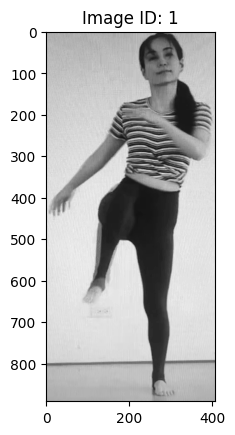

In [ ]:
import matplotlib.pyplot as plt

with open('IDdata/id_first_gray_images.pkl', 'rb') as f:
    id_first_gray_images = pickle.load(f)



for id in id_list:
    # 顯示圖片
    plt.imshow(id_first_gray_images[id], cmap='gray')
    plt.title(f"Image ID: {id}")
    plt.show()

    # 讓使用者輸入名稱
    name = input(f"Please enter a name for ID {id}: ")
    id_to_name[id] = name

# 輸出映射結果
print("ID to Name Mapping:")
for id, name in id_to_name.items():
    print(f"{id}: {name}")


# 6. ID到名稱的映射關系

建立照片資料庫，人臉特徵資料庫，生成運動時間報表

1. **map_ids_to_names 函數**：
   - 將 DataFrame 中的 ID 替換為名稱。
   - 接收 DataFrame、ID 到名稱的映射字典、以及要替換的列名（默認為 'ID'）。
   - 使用 `map` 函數將指定列中的 ID 替換為對應的名稱。

2. **update_image_data 函數**：
   - 將圖片數據中的舊 ID 替換為新 ID 並保存更新後的圖片數據。
   - 從指定的源路徑加載圖片數據。
   - 使用映射字典將舊 ID 替換為新 ID。
   - 將更新後的圖片數據保存到指定的目標路徑，如果目標路徑已有數據則進行合併。

3. **save_combined_data 函數**：
   - 保存合併後的數據到固定路徑的 pickle 文件。
   - 從指定的文件路徑加載已存在的數據，並將新的數據與已存在的數據合併。
   - 如果文件不存在，則創建新的文件並保存數據。
   - 返回合併後的數據。

4. **save_to_csv 函數**：
   - 將 DataFrame 保存到固定路徑的 CSV 文件。
   - 接收 DataFrame 和文件保存路徑，將 DataFrame 轉換為 CSV 格式並保存。

5. **使用示例**：
   - 使用 `map_ids_to_names` 函數將 `merged_df` 和 `combined_reduced_features` 中的 ID 替換為名稱。
   - 使用 `save_combined_data` 函數保存合併後的數據。
   - 使用 `save_to_csv` 函數保存 `merged_df` 到 CSV 文件。
   - 使用 `update_image_data` 函數更新圖片數據中的 ID。

這段程式碼的主要目的是替換數據中的 ID 為名稱，保存更新後的數據和圖片，並將數據保存到指定的文件中。

In [ ]:
import pandas as pd
import pickle

def map_ids_to_names(df, id_to_name, column='ID'):
    """
    使用映射字典將 DataFrame 中的 ID 替換為名稱
    """
    df[column] = df[column].map(id_to_name)
    return df

def update_image_data(id_to_name):
    """
    更新圖片數據，將舊 ID 替換為新 ID，並保存到固定路徑
    """
    source_path = 'IDdata/id_first_gray_images.pkl'
    dest_path = 'Model/images.pkl'
    
    with open(source_path, 'rb') as f:
        data = pickle.load(f)

    new_data = {id_to_name.get(old_key, old_key): value for old_key, value in data.items()}

    try:
        with open(dest_path, 'rb') as f:
            existing_data = pickle.load(f)
        existing_data.update(new_data)
    except FileNotFoundError:
        existing_data = new_data

    with open(dest_path, 'wb') as file:
        pickle.dump(existing_data, file)

def save_combined_data(combined_reduced_features):
    """
    保存合並後的數據到固定路徑的 pickle 文件
    """
    file_path = 'Model/final_reduced_data.pkl'
    
    try:
        with open(file_path, 'rb') as f:
            existing_data = pickle.load(f)
            f_data = pd.concat([existing_data, combined_reduced_features.iloc[:, :513]], ignore_index=True)
            print("Database exists")
    except FileNotFoundError:
        f_data = combined_reduced_features.iloc[:, :513]
        print("The database does not exist, creating the database")
    
    with open(file_path, 'wb') as file:
        pickle.dump(f_data, file)

    return f_data

def save_to_csv(df):
    """
    將 DataFrame 保存到固定路徑的 CSV 文件
    """
    file_path = 'IDdata/merged_id_action_duration.csv'
    df.to_csv(file_path, index=False)

# 使用示例

# 替換 ID 為名稱
merged_df = map_ids_to_names(merged_df, id_to_name)
combined_reduced_features = map_ids_to_names(combined_reduced_features, id_to_name)

# 保存合並後的數據
f_data = save_combined_data(combined_reduced_features)

# 保存 merged_df 到 CSV
save_to_csv(merged_df)

# 更新圖片數據
update_image_data(id_to_name)
